In [ ]:
#default_exp Callbacks.Custom

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Fastai2 Custom Callbacks and Hooks
> Creating your own Callbacks and Hooks to create more dynamic networks with fastai2.

If you've ever tried to implement more complex Deep Learning concepts, like gans, perceptual loss or even making your own, you may have tried making your own version in the model.Maybe after a while of trial and error you would have noticed that the fastai training loop is pretty rigid by default. To overcome this, fastai have two tools.

The first is one we already know, which are callbacks. The ones we viewed before are already built into the library, but these won't always be enough, which is why we need to make our own. Thankfully the fastai library makes it very intuitive to make powerful callbacks that can interviene in any part of the training. I honestly believe that any training loop you might want can be built with these callbacks... unless you want to call functions during the forward pass or back propagation...

This is where hooks come in

# Tests Setup
Getting dataset to setup tests.

In [ ]:
#export
from fastai2.vision.all import *
from fastai2.data.all import *
from nbdev.showdoc import *

In [ ]:
#exports
path = untar_data(URLs.PETS)
path_img, path_anno = [path/folder for folder in path.ls()]

In [ ]:
#exports
pat = r'/(\w+)_\d+.jpg'

dblock = DataBlock((ImageBlock,CategoryBlock),
                    splitter=RandomSplitter(valid_pct=0.8),
                    get_items=get_image_files,
                    item_tfms=Resize(224),
                    batch_tfms=aug_transforms(),
                    get_y=RegexLabeller(pat))

In [ ]:
#exports
dls = dblock.dataloaders(path_img)

# Custom Callbacks
Reviewing what the callbacks can do.

In [ ]:
from fastai2.callback.core import Callback

In [ ]:
show_doc(Callback)

<h2 id="Callback" class="doc_header"><code>class</code> <code>Callback</code><a href="https://github.com/fastai/fastai2/tree/master/fastai2/callback/core.py#L14" class="source_link" style="float:right">[source]</a></h2>

> <code>Callback</code>() :: `GetAttr`

Basic class handling tweaks of the training loop by changing a `Learner` in various events

In [ ]:
show_doc(Callback.__call__)

<h4 id="Callback.__call__" class="doc_header"><code>Callback.__call__</code><a href="https://github.com/fastai/fastai2/tree/master/fastai2/callback/core.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>Callback.__call__</code>(**`event_name`**)

Call `self.{event_name}` if it's defined

In [ ]:
show_doc(Callback.__getattr__)

<h4 id="GetAttr.__getattr__" class="doc_header"><code>GetAttr.__getattr__</code><a href="https://github.com/fastai/fastcore/tree/master/fastcore/foundation.py#L226" class="source_link" style="float:right">[source]</a></h4>

> <code>GetAttr.__getattr__</code>(**`k`**)



# Toy Callback

In [ ]:
class ABCCallback(Callback):
    def __init__(self, first_let:chr="a"):
        store_attr(self, "first_let")
    
    def begin_fit(self):
        "Initialize abc counter"
        self.learn.abc = ""
    
    def begin_batch(self):
        if self.training:
            if self.learn.abc == "": self.learn.abc += self.first_let
            else: self.learn.abc += chr(ord(self.learn.abc[-1]) + 1)

    def after_batch(self):
        if self.training:
            self.learn.abc += self.learn.abc[-1]
    
    def after_fit(self):
        print(self.learn.abc)

epoch,train_loss,valid_loss,error_rate,time
0,3.400828,1.737364,0.441306,00:13


aabbccddeeffgghhiijjkkllmmnnooppqqrrssttuuvvww


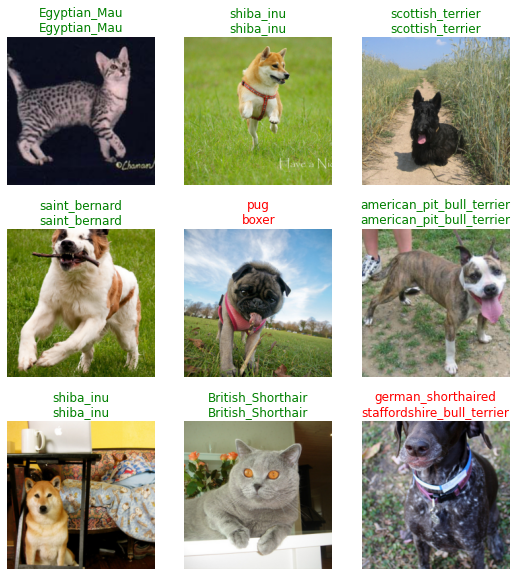

In [ ]:
cbs = (ABCCallback())
learner = Learner(dls, resnet34(pretrained=True), metrics=error_rate)
learner.fit_one_cycle(1, cbs=cbs)
learner.show_results()

# Pytorch Hooks

## Single Layer Hooks

In [ ]:
from fastai2.callback.hook import Hook, Hooks, HookCallback

In [ ]:
tst_model = torch.nn.Linear(5,3)
i = torch.randn(4,5)
i

tensor([[-5.5425e-01, -5.3988e-01, -2.0818e+00,  2.2344e+00, -4.4065e-01],
        [-4.3081e-01, -2.8205e-01,  1.9477e-03,  1.2543e+00, -1.0193e+00],
        [-7.1371e-01, -2.0167e+00, -2.1808e-01, -1.0877e+00,  7.8380e-01],
        [-8.2599e-01,  8.4996e-01, -2.9480e-01, -6.7576e-01, -1.0430e-01]])

In [ ]:
def input_printer(m,i,o): print(f"input is {i}")

def output_printer(m,i,o): print(f"output is {o}")

InputPrinterHook = Hook(tst_model, input_printer)
OutputPrinterHook = Hook(tst_model, output_printer)

In [ ]:
o = tst_model(i)
o

input is (tensor([[-5.5425e-01, -5.3988e-01, -2.0818e+00,  2.2344e+00, -4.4065e-01],
        [-4.3081e-01, -2.8205e-01,  1.9477e-03,  1.2543e+00, -1.0193e+00],
        [-7.1371e-01, -2.0167e+00, -2.1808e-01, -1.0877e+00,  7.8380e-01],
        [-8.2599e-01,  8.4996e-01, -2.9480e-01, -6.7576e-01, -1.0430e-01]]),)
output is tensor([[ 0.0723,  0.7656, -1.1304],
        [ 0.0811,  0.1156, -0.1220],
        [ 0.6650,  1.1519,  0.4291],
        [-0.2292,  0.0330, -0.5506]])


tensor([[ 0.0723,  0.7656, -1.1304],
        [ 0.0811,  0.1156, -0.1220],
        [ 0.6650,  1.1519,  0.4291],
        [-0.2292,  0.0330, -0.5506]], grad_fn=<AddmmBackward>)

In [ ]:
InputPrinterHook.remove()
OutputPrinterHook.remove()

In [ ]:
o = tst_model(i)
o

tensor([[ 0.0723,  0.7656, -1.1304],
        [ 0.0811,  0.1156, -0.1220],
        [ 0.6650,  1.1519,  0.4291],
        [-0.2292,  0.0330, -0.5506]], grad_fn=<AddmmBackward>)